In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, 
    average_precision_score, 
    precision_recall_curve,
    brier_score_loss
)

# Use your existing data splits [cite: 104, 105]
train_path = Path("data/processed/splits/train/train.csv")
val_path = Path("data/processed/splits/val/val.csv")
X_train, y_train = pd.read_csv(train_path)["comment"].astype(str), pd.read_csv(train_path)["sentiment"]
X_val, y_val = pd.read_csv(val_path)["comment"].astype(str), pd.read_csv(val_path)["sentiment"]

# Label Mapping for negative=0, positive=1 [cite: 476, 478]
y_train = y_train.map({"negative": 0, "positive": 1}).astype(int)
y_val = y_val.map({"negative": 0, "positive": 1}).astype(int)

In [12]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Experiment 1: Linear SVM with 'balanced' weights to handle 80/20 split [cite: 93]
svm_linear_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), min_df=1, sublinear_tf=True)),
    ('svm', CalibratedClassifierCV(
        LinearSVC(C=5.0, dual=True, max_iter=2000),
        method='isotonic', 
        cv=5
    ))
])

# Fitting the model [cite: 506]
svm_linear_pipe.fit(X_train, y_train)

# Quick Check
y_pred = svm_linear_pipe.predict(X_val)
print("Linear SVM (Balanced) Results:\n", classification_report(y_val, y_pred))

Linear SVM (Balanced) Results:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       479
           1       0.97      0.95      0.96      1592

    accuracy                           0.95      2071
   macro avg       0.92      0.94      0.93      2071
weighted avg       0.95      0.95      0.95      2071



[ 7  9  9 ...  9  9 -1]
[ 196   27   19   14   11   20   18   28   42 1449]


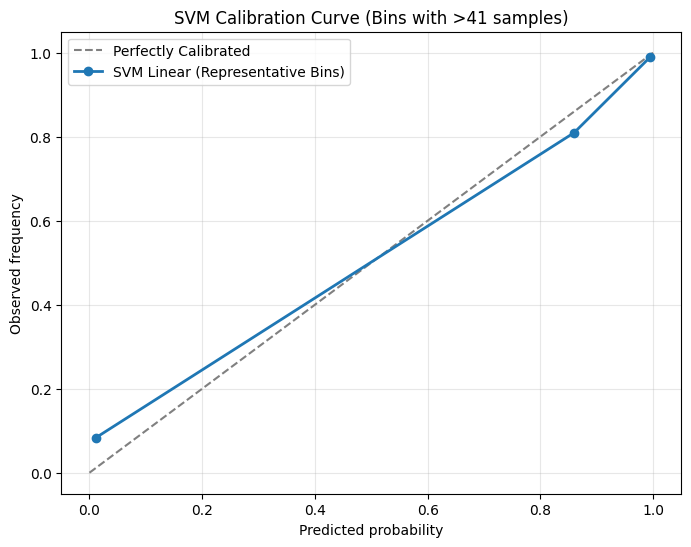

Total Bins: 10
Bins kept: 3
Bins discarded: 7


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# 1. Get probabilities for the positive class
probs = svm_linear_pipe.predict_proba(X_val)[:, 1]

# 2. Compute calibration curve
# We use more bins initially to identify sparse areas
n_bins = 10 
fop, mpv = calibration_curve(y_val, probs, n_bins=n_bins, strategy="uniform")

# 3. Calculate the number of samples in each bin to identify representative data
# We digitize the probabilities to match them to the n_bins
bin_indices = np.digitize(probs, np.linspace(0, 1, n_bins + 1), right=True) - 1
print(bin_indices)

bin_counts = np.array([np.sum(bin_indices == i) for i in range(n_bins)]) 
print(bin_counts)


# 4. Set a threshold for "considerable number of data points"
# E.g., at least 2% of the total validation samples 
threshold = 0.02 * len(y_val) 
representative_mask = bin_counts >= threshold

# 5. Filter the calibration results
fop_filtered = fop[representative_mask]
mpv_filtered = mpv[representative_mask]

# 6. Plotting
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated') 
plt.plot(mpv_filtered, fop_filtered, marker='o', linewidth=2, label='SVM Linear (Representative Bins)') 

plt.xlabel("Predicted probability") 
plt.ylabel("Observed frequency") 
plt.title(f"SVM Calibration Curve (Bins with >{int(threshold)} samples)") 
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print the discarded bin info for transparency
print(f"Total Bins: {n_bins}")
print(f"Bins kept: {np.sum(representative_mask)}")
print(f"Bins discarded: {n_bins - np.sum(representative_mask)}")

In [9]:
from sklearn.svm import SVC

# Experiment 2: RBF Kernel (Non-Linear)
# NOTE: This will be significantly slower than LinearSVC due to O(m^2) complexity
svm_rbf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1), min_df=10)), # Simplify features for speed
    ('svm', SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True))
])

svm_rbf_pipe.fit(X_train, y_train)

y_pred = svm_rbf_pipe.predict(X_val)
print("Linear SVM (Balanced) Results:\n", classification_report(y_val, y_pred))

Linear SVM (Balanced) Results:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       479
           1       0.97      0.96      0.97      1592

    accuracy                           0.95      2071
   macro avg       0.92      0.94      0.93      2071
weighted avg       0.95      0.95      0.95      2071



In [4]:
# Test 1: Standard Linear SVM with Squared Hinge Loss
# Squared Hinge is smoother and often more stable for sparse TF-IDF data.
linear_svm = LinearSVC(
    loss="squared_hinge", 
    dual=True,        # Faster when n_features > n_samples (57k vs 10k)
    C=1.0,            # Tuning C: lower = more regularization (ignores noise like 'muy')
    class_weight="balanced", # Essential for your 80/20 imbalance
    max_iter=2000
)

# Calibration is vital as SVMs produce raw scores, not probabilities 
calibrated_svm = CalibratedClassifierCV(
    linear_svm, 
    method="isotonic", # Consistent with your LogReg trial [cite: 498]
    cv=5
)

Non linear SVM

In [ ]:
# Experiment B: RBF (Gaussian) vs Poly Kernels
# RBF can handle complex sentiment patterns where words interact non-linearly.
rbf_svm = SVC(
    kernel="rbf", 
    gamma="scale",   # Controls the 'reach' of a single training example
    C=1.0,           # Same regularization logic
    probability=True # Uses Platt scaling internally (slower than CalibratedClassifierCV)
)

In [5]:
# Reuse your existing threshold logic [cite: 835-845]
p_neg = calibrated_svm.predict_proba(X_val)[:, 0]
precision_neg, recall_neg, thresholds = precision_recall_curve(y_val == 0, p_neg)

target_recall = 0.90
valid_idxs = np.where(recall_neg >= target_recall)[0]
best_thresh = thresholds[valid_idxs[-1]]

print(f"SVM Threshold for 90% Recall: {best_thresh:.4f}")

NotFittedError: This CalibratedClassifierCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.